<a href="https://colab.research.google.com/github/anyaconda/myNumerai/blob/main/myNumerai_linear_withDanielStarterKit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introduction
This notebook will walk you through the entire process of making a [numerai](numer.ai) submission, from downloading the data to submitting final predictions, all in a google colab notebook. In particular, it will address two challenges:
- handling API keys in a remote environment (colab)
- parsing the large CSV files which, if read all at once, will exceed colab's memory and cause the notebook to crash.

This notebook will implement two models: a basic tabular neural network using `fastai` and a linear regression model using `scikit-learn`.

## 1.1 Installing and Importing Dependencies
First, we install and import the necessary packages. This cell is currently set *not* to print any output; if you run into any issues and need to check for error messages, comment out the `%%capture` line

In [ ]:
%%capture
# install
!pip install --upgrade python-dotenv fastai numerapi

# import dependencies
import gc
import os
from dotenv import load_dotenv, find_dotenv
from getpass import getpass
import pandas as pd
import numpy as np
import numerapi
from fastai.tabular.all import *
from pathlib import Path
from scipy.stats import spearmanr
import sklearn.linear_model
from tqdm import tqdm

## 1.2 Setting Up numerapi
We will use the [numerapi](https://github.com/uuazed/numerapi) package to access the data and make submissions. For this to work, numerapi needs to use your API keys (which can be obtained [here](https://numer.ai/submit)). We will set up two main ways of passing these API keys to a numerapi instance:
1. Read a `.env` file using the `python-dotenv` package. This will require you to upload a `.env` file (which contains your secret key and should *not* be kept under version control). Using this method means you will not have to directly enter your keys each time you use this notebook, though you will need to re-upload the `.env` file.
2. Manually entering the API keys -- if you don't have access to, or don't want to mess with, your `.env` file.

If you have a `.env` file, upload it to the default working directory, `content`, now. In either case, run the cell below to set up the numerapi instance. See [Appendix A](#app_a) for instructions on generating and downloading a .env file.

In [ ]:
# Load the numerapi credentials from .env or prompt for them if not available
def credential():
    dotenv_path = find_dotenv()
    load_dotenv(dotenv_path)

    if os.getenv("NUMERAI_PUBLIC_KEY"):
        print("Loaded Numerai Public Key into Global Environment!")
    else:
        os.environ["NUMERAI_PUBLIC_KEY"] = getpass("Please enter your Numerai Public Key. You can find your key here: https://numer.ai/submit -> ")
    
    if os.getenv("NUMERAI_SECRET_KEY"):
        print("Loaded Numerai Secret Key into Global Environment!")
    else:
        os.environ["NUMERAI_SECRET_KEY"] = getpass("Please enter your Numerai Secret Key. You can find your key here: https://numer.ai/submit -> ")
    
    if os.getenv("NUMERAI_MODEL_ID"):
        print("Loaded Numerai Model ID into Global Environment!")
    else:
        os.environ["NUMERAI_MODEL_ID"] = getpass("Please enter your Numerai Model ID. You can find your key here: https://numer.ai/submit -> ")

credential()
public_key = "" #os.environ.get("NUMERAI_PUBLIC_KEY")
secret_key = "" #os.environ.get("NUMERAI_SECRET_KEY")
model_id = "" #os.environ.get("NUMERAI_MODEL_ID")
napi = numerapi.NumerAPI(verbosity="info", public_id=public_key, secret_key=secret_key)

Loaded Numerai Public Key into Global Environment!
Loaded Numerai Secret Key into Global Environment!
Loaded Numerai Model ID into Global Environment!


You can read up on the functionality of numerapi [here](https://github.com/uuazed/numerapi). You can use it to download the competition data, view other numerai users' public profiles, check submission status, manage your stake, and much more. In this case, we'll only be using it to download competition data and submit predictions.

## 1.3 Downloading Competition Data
In a more structured project, you'll probably want to keep the data in a seprate directory from your scripts etc. You could also link google colab to your google drive and store the data there in order to avoid needing to download and process the data every time. In this case, however, we'll keep everything in `./content`, and download the data fresh each time.

In [ ]:
napi.download_current_dataset()

2021-03-07 07:46:12,306 INFO numerapi.base_api: target file already exists


'./numerai_dataset_254.zip'

## 1.4 Generating the Training Sample

If you look at the files we downloaded above, you'll see a `numerai_tournament_data.csv` file and a `numerai_training_data.csv` file. The "tournament" file contains many rows with targets which we can use for validation, so let's extract those and combine them with our training set. Note that this cell saves a new `csv` after combining the training and validation data, so we can avoid the time-consuming parsing process if we run this cell again in the same session.

In [ ]:
tourn_file = Path(f'./numerai_dataset_{napi.get_current_round()}/numerai_tournament_data.csv')
train_file = Path(f'./numerai_dataset_{napi.get_current_round()}/numerai_training_data.csv')
processed_train_file = Path('./training_processed.csv')

if processed_train_file.exists():
    print("Loading the processed training data from file\n")
    training_data = pd.read_csv(processed_train_file)
else:
    tourn_iter_csv = pd.read_csv(tourn_file, iterator=True, chunksize=1e6)
    val_df = pd.concat([chunk[chunk['data_type'] == 'validation'] for chunk in tqdm(tourn_iter_csv)])
    tourn_iter_csv.close()
    training_data = pd.read_csv(train_file)
    training_data = pd.concat([training_data, val_df])
    training_data.reset_index(drop=True, inplace=True)
    print("Training Dataset Generated! Saving to file ...")
    training_data.to_csv(processed_train_file, index=False)


feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]
target_cols = ['target']

train_idx = training_data.index[training_data.data_type=='train'].tolist()
val_idx = training_data.index[training_data.data_type=='validation'].tolist()

Loading the processed training data from file



In [58]:
#basic counts
len(train_idx), len(val_idx)

(501808, 137779)

In [48]:
print(training_data.shape)
print(training_data["data_type"].unique())
training_data["data_type"].value_counts(dropna=False)

(639587, 314)
['train' 'validation']


train         501808
validation    137779
Name: data_type, dtype: int64

# 2 Modeling the Data

In this section, we will define our evaluation metrics; run two different models (a linear regression model from `scikit-learn` and a neural network from `fastai`); and generate submission dataframes from those files.

## 2.1 Evaluation Metrics

In this section, we will define two key evaluation metrics used to assess the performance of models before submitting to the tournament. These metrics are:
- Average Spearman Correlation per era: The sum of each era's Spearman correlation divided by the number of eras.
- Sharpe Ratio: The average correlation per era divided by the standard deviation of the correlations per era.

Both are defined in reasonable detail [here](https://wandb.ai/carlolepelaars/numerai_tutorial/reports/How-to-get-Started-With-Numerai--VmlldzoxODU0NTQ). The methods defined below are modified versions of the methods described in that post.

In [ ]:
def corr(df: pd.DataFrame) -> np.float32:
    """
    Calculate the correlation by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The average per-era correlations.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() 

def sharpe(df: pd.DataFrame) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

## 2.2 Models

### 2.2.1 Linear Regression Model
This model closely follows the tutorial example [here](https://colab.research.google.com/github/numerai/example-scripts/blob/master/making-your-first-submission-on-numerai.ipynb). We will use the `scikit-learn` package, with which we can implement and fit our regression model in just a couple of lines of code.

#### Fitting the Linear Regression Model

In [ ]:
train_sample = training_data.iloc[train_idx]
model = sklearn.linear_model.LinearRegression()
model.fit(train_sample[feature_cols], train_sample.target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Assessing Regression Model Performance

Here we apply the `corr` and `sharpe` methods defined above to predictions made on the validation sample in order to estimate our model's tournament performance.

In [ ]:
val_sample = training_data.iloc[val_idx]
val_preds = model.predict(val_sample[feature_cols])
eval_df = pd.DataFrame({'prediction':val_preds,
                        'target':val_sample.target,
                        'era':val_sample.era}).reset_index()
val_sharpe = sharpe(eval_df)
val_corr = corr(eval_df)

print((f'The linear regression model\'s validation correlation is {val_corr}. '
       f'Its validation sharpe is {val_sharpe}'))

The linear regression model's validation correlation is 0.016246523230621295. Its validation sharpe is 0.5236836981840626


In [60]:
#basic counts
train_sample.shape, val_sample.shape

((501808, 314), (137779, 314))

In [52]:
#check for nulls in validation sample - none - adds up to 137779
val_sample.target.value_counts(dropna=False)

0.50    68954
0.75    27533
0.25    27531
1.00     6882
0.00     6879
Name: target, dtype: int64

In [64]:
#validate predictions - validation set
predictions = model.predict(val_sample[feature_cols])
y_hat = pd.Series(predictions)
print(y_hat.shape)
y_hat.head()

(137779,)


0    0.481608
1    0.492837
2    0.530817
3    0.497083
4    0.503089
dtype: float64

In [104]:
#evaluate predictions
n_valid = val_sample['target'].shape[0]
y_valid = val_sample['target'].reset_index(drop=True)
loss = y_valid - y_hat

In [106]:
#calculate mse, rmse
mse = (loss**2).sum() / n_valid
rmse = np.sqrt(mse)
mse, rmse

(0.05000330403245911, 0.2236141856691098)

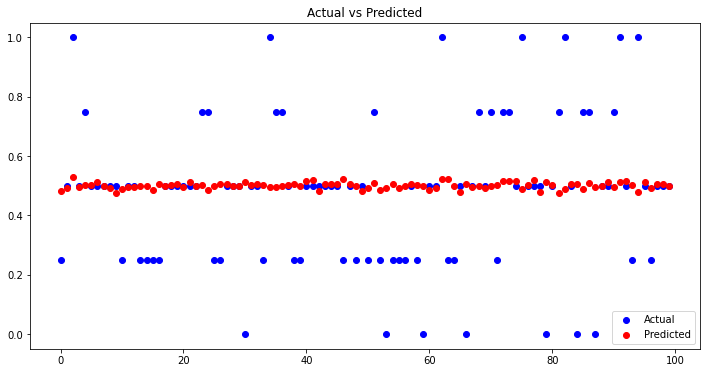

In [107]:
#preview first 100 stocks
plt.figure(figsize=(12,6))
plt.title("Actual vs Predicted")

plt.scatter(np.arange(100), y_valid[:100], color='b', label='Actual')
plt.scatter(np.arange(100), y_hat[:100], color='r', label='Predicted')
plt.legend(loc='lower right')

plt.show()

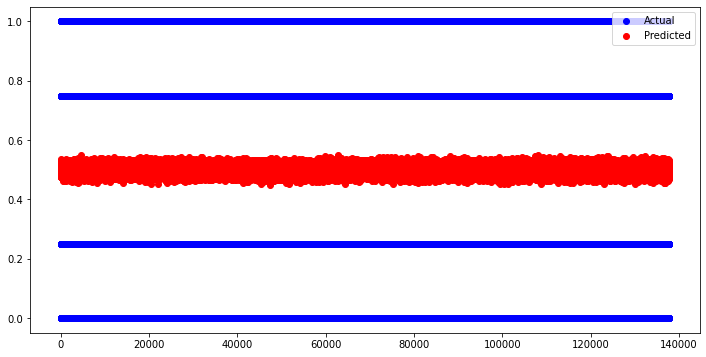

In [108]:
#view all
plt.figure(figsize=(12,6))

plt.scatter(np.arange(n_valid), y_valid, color='blue', label='Actual')
plt.scatter(np.arange(n_valid), y_hat, color='red', label='Predicted')
plt.legend(loc='upper right')

plt.show()

#### Making Predictions with the Regression Model

In [62]:
tourn_iter_csv.__class__

pandas.io.parsers.TextFileReader

In [ ]:
ids = []
preds = []

chunksize = 50000

tourn_iter_csv = pd.read_csv(tourn_file, iterator=True, chunksize=1e6)
for chunk in tourn_iter_csv:
    df = chunk[feature_cols]
    out = model.predict(df)
    ids.extend(chunk["id"])
    preds.extend(out)
tourn_iter_csv.close()

In [53]:
#evaluate predictions
n_valid = len(preds)
n_valid
#loss = y_valid - y_hat

1665898

In [ ]:
linear_regression_predictions_df = pd.DataFrame({
    'id':ids,
    'prediction':preds
})
linear_regression_predictions_df.head()

,id,prediction
0,n0003aa52cab36c2,0.481608
1,n000920ed083903f,0.492837
2,n0038e640522c4a6,0.530817
3,n004ac94a87dc54b,0.497083
4,n0052fe97ea0c05f,0.503089


In [57]:
#verify counts in predictions
len(ids)


1665898

In [ ]:
linear_regression_predictions_df.to_csv("lr_predictions.csv", index=False)

#### Submitting Predictions from the Linear Regression Model

We can use `numerapi` to submit these predictions as follows:

In [ ]:
napi.upload_predictions("lr_predictions.csv", model_id=model_id)
#napi.upload_predictions("lr_predictions.csv", tournament=napi.get_current_round())
# check submission status
napi.submission_status(model_id)


2021-03-07 07:57:46,261 INFO numerapi.base_api: uploading predictions...


{'concordance': None,
 'consistency': None,
 'corrWithExamplePreds': 0.6548457849212914,
 'filename': 'lr_predictions-SkYkDf9ugzTD.csv',
 'validationCorrPlusMmcSharpe': 0.35938766649104026,
 'validationCorrPlusMmcSharpeDiff': -0.18488855124755244,
 'validationCorrPlusMmcSharpeDiffRating': 0.13022289750489513,
 'validationCorrPlusMmcSharpeRating': 0.0,
 'validationCorrelation': 0.01614316503907205,
 'validationCorrelationRating': 0.2095443359381366,
 'validationFeatureExposure': None,
 'validationFeatureNeutralMean': 0.0027748435153194567,
 'validationFeatureNeutralMeanRating': 0.0,
 'validationMaxDrawdown': -0.12335426339327116,
 'validationMaxDrawdownRating': 0.0,
 'validationMaxFeatureExposure': 0.27920374641560514,
 'validationMaxFeatureExposureRating': 0.36177374538602836,
 'validationMmcMean': -0.0009435622280361547,
 'validationMmcMeanRating': 0.44102736074774035,
 'validationSharpe': 0.5442762177385927,
 'validationSharpeRating': 0.020107348927595307,
 'validationStd': 0.0296598

In [ ]:
print(model_id)
mystop

e6424243-8bb5-4468-9baa-17d499149ee0


NameError: ignored

### 2.2.2 Fastai Neural Network
In this section, we use fastai's tabular data processing and modeling capabilities to develop a neural network ([fastai](https://docs.fast.ai/tabular.core.html)).

#### Preparing the Data

We use the [`TabularPandas`](https://docs.fast.ai/tabular.core.html#TabularPandas) class to set up our DataLoaders. We will use a relatively large batch size (`bs=2048`) to facilitate rapid training in this example.

In [ ]:
splits = (list(train_idx), list(val_idx))
data = TabularPandas(training_data, cat_names=None,
                    cont_names=list(feature_cols.values),
                    y_names=target_cols, splits = splits)

dls = data.dataloaders(bs = 2048)

#### Set Up and Fit Fastai Model

In this simple example, we will make no attempt to optimize hyperparameters. You can experiment with the batch size, which we set above, along with the number and size of layers, weight decay, and many of the additional configuration options listed [here](https://docs.fast.ai/tabular.model.html#TabularModel).

**Note:** The following cell will run much faster if you are using a colab session with GPU enabled.

In [ ]:
learn = tabular_learner(dls, layers=[200,200],
                        loss_func=MSELossFlat(),
                        metrics = [PearsonCorrCoef()])

learn.fit_one_cycle(3, wd = 0.1)

#### Evaluate Performance of Fastai Model

As we did with the regression model, we'll check the validation correlation and sharpe score of this fastai neural network.

In [ ]:
prediction, target = learn.get_preds()
prediction = prediction.numpy().squeeze()
target = target.numpy().squeeze()

era = dls.valid_ds.items['era']
eval_df = pd.DataFrame({'prediction':prediction, 'target':target, 'era':era}).reset_index()

val_sharpe = sharpe(eval_df)
val_corr = corr(eval_df)

print((f'The fastai tabular neural network\'s validation correlation is {val_corr}. '
       f'Its validation sharpe is {val_sharpe}'))

#### Making Predictions with the Fastai Model

There is probably a way to significantly simplify the following cell.

In [ ]:
ids = []
preds = []

chunksize = 75000

tourn_iter_csv = pd.read_csv(tourn_file, iterator=True, chunksize=chunksize)
for chunk in tourn_iter_csv:
    chunk.drop(columns = 'target', inplace = True)
    test_dl = dls.test_dl(chunk)
    preds_out,_ = learn.get_preds(dl = test_dl, inner = True)
    preds_out = preds_out.tolist()
    preds_out = [item for sublist in preds_out for item in sublist]
    ids_out = chunk["id"]
    preds.extend(preds_out)
    ids.extend(ids_out)
tourn_iter_csv.close()
#preds_out = [item for sublist in preds for item in sublist]
#ids_out = [item for sublist in ids for item in sublist]

fastai_predictions_df = pd.DataFrame({
'id':ids,
'prediction':preds
})

fastai_predictions_df.head()

#### Submitting Predictions from the Fastai Model

In [ ]:
fastai_predictions_df.to_csv("fastai_predictions.csv", index=False)
napi.upload_predictions("fastai_predictions.csv", model_id=os.environ.get("NUMERAI_MODEL_ID"))

<a name="app_a"></a>
# Appendix A

## Generating and Saving a `.env` file
I recommend filling out this section to generate a `.env` file and then downloading that file for future use. Then, the next time you want to run this notebook, upload the `.env` file and you will not need to enter your credentials manually.

In [ ]:
# Write lines to file

with open('./.env', 'w') as dotenv:
    dotenv.write(f'NUMERAI_PUBLIC_KEY = {getpass("Please enter your Numerai Public Key. You can find your key here: https://numer.ai/submit -> ")}\n')
    dotenv.write(f'NUMERAI_SECRET_KEY = {getpass("Please enter your Numerai Secret Key. You can find your key here: https://numer.ai/submit -> ")}\n')
    dotenv.write(f'NUMERAI_MODEL_ID = {getpass("Please enter your Numerai Model ID. You can find your key here: https://numer.ai/submit -> ")}\n')

To confirm that this worked, you can run `!cat .env` in a new cell and check the output against the values on https://numer.ai/submit. Make sure no one is looking, and that you don't save the output where others on the Internet can find it!

If you want to download this `.env` file for future use (e.g. to re-upload the next time you want to use this notebook), run the next cell:

In [ ]:
from google.colab import files
files.download("./.env")